# Lung Cancer Survival Prediction Endpoint Demo

In this endpoint demo notebook, we demonstrate how to send inference requests to an pre-deployed endpoint and get the model response (survived vs death). 

To find more details of an end-to-end solution for data processing, feature store, model training and deployement using SageMaker, check out the solution notebook [1_preprocess_genomic_data.ipynb](./1_preprocess_genomic_data.ipynb) to start the end-to-end solution. The end-to-end solution shows how-to for the following steps: 1/ processing multi-modal data (genomic, clinical, medical imaging) to obtain ML features, 2/ ingesting and managing multi-modal features in SageMaker Feature Store, 3/ training a survival status prediction model using PCA and XGBoost, 4/ hosting a model for inference. The exposition in this notebook is deliberately brief. 

>**<span style="color:RED">Important</span>**: 
>This solution is for demonstrative purposes only. It is not for clinical use. The ML inference should not be used to inform any clinical decision. The associated notebooks, including the trained model and sample data, are not intended for production.

### (dev only) Hosting a trained model from local model.tar.gz
This section ought to be removed once tested by solution team. JS team should not include this section in integration test.

In [2]:
import sagemaker
import boto3
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

default_bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sagemaker-soln-lcsp-js'

In [3]:
model_local = './js-us-west-2-output/model.tar.gz'
model_s3_prefix = f's3://{default_bucket}/{prefix}/js-us-west-2-output'
model_s3_uri = sagemaker.s3.S3Uploader.upload(model_local, model_s3_prefix, sagemaker_session=sagemaker_session)

In [4]:
image = sagemaker.image_uris.retrieve('xgboost', region=region, version='1.2-1')
model = sagemaker.model.Model(image, model_data=model_s3_uri, role = role, sagemaker_session=sagemaker_session)

In [5]:
import uuid
suffix=uuid.uuid1().hex[:5] # to be used in resource names
endpoint_name = f'sagemaker-soln-lcsp-js-{suffix}'
model.deploy(initial_instance_count=1, instance_type='ml.t2.large', endpoint_name=endpoint_name)

---------!

### Step 1: Read in the solution config

In [18]:
# TODO JS team to uncomment this part
# import json

# SOLUTION_CONFIG = json.load(open("stack_outputs.json"))
# ROLE = SOLUTION_CONFIG["IamRole"]
# SOLUTION_BUCKET = SOLUTION_CONFIG["SolutionS3Bucket"]
# REGION = SOLUTION_CONFIG["AWSRegion"]
# SOLUTION_NAME = SOLUTION_CONFIG["SolutionName"]
# BUCKET = SOLUTION_CONFIG["S3Bucket"]

### Step 2: Download and read in the multimodal dataset for inference

The test multimodal dataset consists of genomic, clinical and imaging features for X patients. The features have been condensed by PCA from 216 to 65 principal components.

In [19]:
# TODO JS team to uncomment this part
# from sagemaker.s3 import S3Downloader

# input_data_bucket = f"s3://{SOLUTION_BUCKET}-{REGION}/{SOLUTION_NAME}/data"
# print("original data: ")
# S3Downloader.list(input_data_bucket)

#### Download the data for inference from S3

In [20]:
# TODO JS team to uncomment this part
# inference_data = f"{input_data_bucket}/test.csv"
# !aws s3 cp $inference_data .

In [6]:
import pandas as pd

df_test = pd.read_csv("js-us-west-2-output/test.csv", header=None)
print(df_test.shape)

(24, 66)


In [7]:
# Separate the labels from the test dataset
groundtruth = df_test[0].values
df_test = df_test.drop(columns=[0])

The features are principal components computed from 216 features. The original feature vector include features from genomic secondary analysis, clinical health records, and radiomic features from within the lung tumor in computed tomography images. 

#### Snapshot of data
##### Clinical
![clinical-data](../images/clinical-data-screenshot.png)

##### Genomic
![genomic-data](../images/genomic-secondary.png)

##### Medical imaging
![imaging-data](../images/CT-tumor-overlay.png)

### Step 3: Predicting survival status

If you want to use the demo endpoint successfully, your dataframe columns should be identical to the `df_tabtext_score` as shown in the previous step.

In [17]:
import sagemaker
from sagemaker import Predictor
import numpy as np
from sagemaker.predictor import json_serializer, json_deserializer, Predictor

## TODO JS team should uncomment next line.
# endpoint_name = SOLUTION_CONFIG["SolutionPrefix"] + "-demo-endpoint" 

# Make prediction requests to an Amazon SageMaker endpoint.
predictor = Predictor(
    endpoint_name = endpoint_name,
    sagemaker_session = sagemaker.Session(),
    deserializer =  sagemaker.deserializers.CSVDeserializer(),
    serializer = sagemaker.serializers.CSVSerializer(),
)

# Retrieve predictions by passing the test dataset to the Predictor's predict method.
prediction = predictor.predict(df_test.values)
prediction

[['0.6617534756660461',
  '0.3438335657119751',
  '0.48236820101737976',
  '0.49761149287223816',
  '0.23548656702041626',
  '0.3265708386898041',
  '0.6517200469970703',
  '0.6288039684295654',
  '0.20596586167812347',
  '0.30744698643684387',
  '0.2527482211589813',
  '0.21774405241012573',
  '0.6496288776397705',
  '0.6573070883750916',
  '0.5042654275894165',
  '0.5637736320495605',
  '0.22635935246944427',
  '0.22126898169517517',
  '0.7308969497680664',
  '0.2431083768606186',
  '0.22537173330783844',
  '0.39195966720581055',
  '0.5438459515571594',
  '0.5551328659057617']]

In [9]:
# Since the predictions are strings, let's convert them back to floats. 
# The response is an list of lists, let's retrieve list of our predictions.
# prediction = prediction[0]
prediction_float = [float(pred) for pred in prediction[0]]
prediction_float

[0.6617534756660461,
 0.3438335657119751,
 0.48236820101737976,
 0.49761149287223816,
 0.23548656702041626,
 0.3265708386898041,
 0.6517200469970703,
 0.6288039684295654,
 0.20596586167812347,
 0.30744698643684387,
 0.2527482211589813,
 0.21774405241012573,
 0.6496288776397705,
 0.6573070883750916,
 0.5042654275894165,
 0.5637736320495605,
 0.22635935246944427,
 0.22126898169517517,
 0.7308969497680664,
 0.2431083768606186,
 0.22537173330783844,
 0.39195966720581055,
 0.5438459515571594,
 0.5551328659057617]

Let's evaluate the model performance on this sample data against the ground truth using the ROC curve (Receiver Operating Characteristic curve) and AUC (Area Under the Curve) for ROC.

In [13]:
# plot ROC curve, and compute AUC score using the probability
fpr, tpr, thresholds = skm.roc_curve(groundtruth, prediction_float)
skm.auc(fpr, tpr)

0.8125

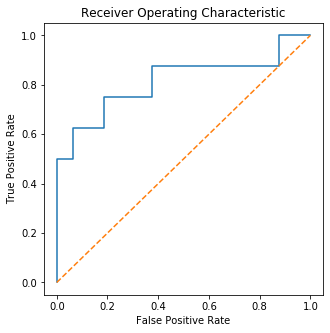

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
# plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Let's convert the probability to hard prediction, survive (1) or death (0) by a set threshold of 0.5.

In [10]:
predictions_label = [1 if pred > 0.5 else 0 for pred in prediction_float]
predictions_label

[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]

In [11]:
import sklearn.metrics as skm
target_names = [False, True]
skm.confusion_matrix(groundtruth, predictions_label)

array([[12,  4],
       [ 2,  6]])

In [12]:
print(skm.classification_report(groundtruth, predictions_label))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.60      0.75      0.67         8

    accuracy                           0.75        24
   macro avg       0.73      0.75      0.73        24
weighted avg       0.77      0.75      0.76        24

